# Alcohol Consumption and Student Performance

## Introduction

Drinking alcohol is part of daily life for many people. Many students also drink alcohol as a means to cope with stress. However alcohol can damage people's bodies, nerves (1) and lead to aggressive behavior (2). Our group was interested in whether alcohol consumption has an effect on the performance of different types of students. According to a study by Ansari, Stock and Mills in 2013, alcohol consumption is negatively associated with student achievement (3). For our group project, we chose to use the data, specifically the processed student alcohol consumption dataset (https://www.kaggle.com/datasets/uciml/student-alcohol-consumption). The dataset contains students' gender, age, length of study, number of absences, weekend alcohol consumption (presented as a scale from 1 to 5, with 1 being very low and 5 being very high) and final grades (G3). The question we wish to investigate is whether weekend drinking has a greater effect on student academic grades. We will determine the final conclusion by calculating a location parameter consisting of the mean of student grades among two groups -- high alcohol consumption and low alcohol consumption. We are also interested in calculating an inter-quartile range (IQR) as the scale parameter.

## Preliminary Results

### Preparing Data

Reading data from the web

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)
library(digest)
library(infer)
library(repr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
url <-"https://raw.githubusercontent.com/jtan29/stat-201-project/main/student-mat.csv"
student_data <- read_csv(url)
head(student_data)

Rows: 395 Columns: 33
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (17): school, sex, address, famsize, Pstatus, Mjob, Fjob, reason, guardi...
dbl (16): age, Medu, Fedu, traveltime, studytime, failures, famrel, freetime...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10
GP,F,15,U,GT3,T,4,2,health,services,⋯,3,2,2,1,1,5,2,15,14,15
GP,F,16,U,GT3,T,3,3,other,other,⋯,4,3,2,1,2,5,4,6,10,10
GP,M,16,U,LE3,T,4,3,services,other,⋯,5,4,2,1,2,5,10,15,15,15


Selecting relevant columns: student final grade and level of weekend alcohol consumption. Alcohol consumption amount is provided on a scale of 1 to 5, with 1 being very low and 5 being very high. We have denoted a consumption level above 2 to be "high".

In [3]:
student_data_clean <- 
    student_data %>%
    select(Walc, G3) %>%
    mutate(high_alc = Walc > 2)

head(student_data_clean)

Walc,G3,high_alc
<dbl>,<dbl>,<lgl>
1,6,FALSE
1,6,FALSE
3,10,TRUE
1,15,FALSE
2,10,FALSE
2,15,FALSE


### Analysis of Raw Data

Then, we determine the average grade and the standard deviation of grades for the high and low consumption groups.

In [4]:
student_summary <-
    student_data_clean %>%
    group_by(high_alc) %>%
    summarize(count = n(),
             mean_grade = mean(G3),
             sd_grade = sd(G3))

low_alc_mean = student_summary$mean_grade[[1]]
high_alc_mean = student_summary$mean_grade[[2]]
total_count = student_summary$count[[1]] + student_summary$count[[2]]
student_summary
total_count

high_alc,count,mean_grade,sd_grade
<lgl>,<int>,<dbl>,<dbl>
FALSE,236,10.50000,5.067628
TRUE,159,10.28931,3.757433


[1] 395

Then we plot the sampling distribution of student grades for both groups.

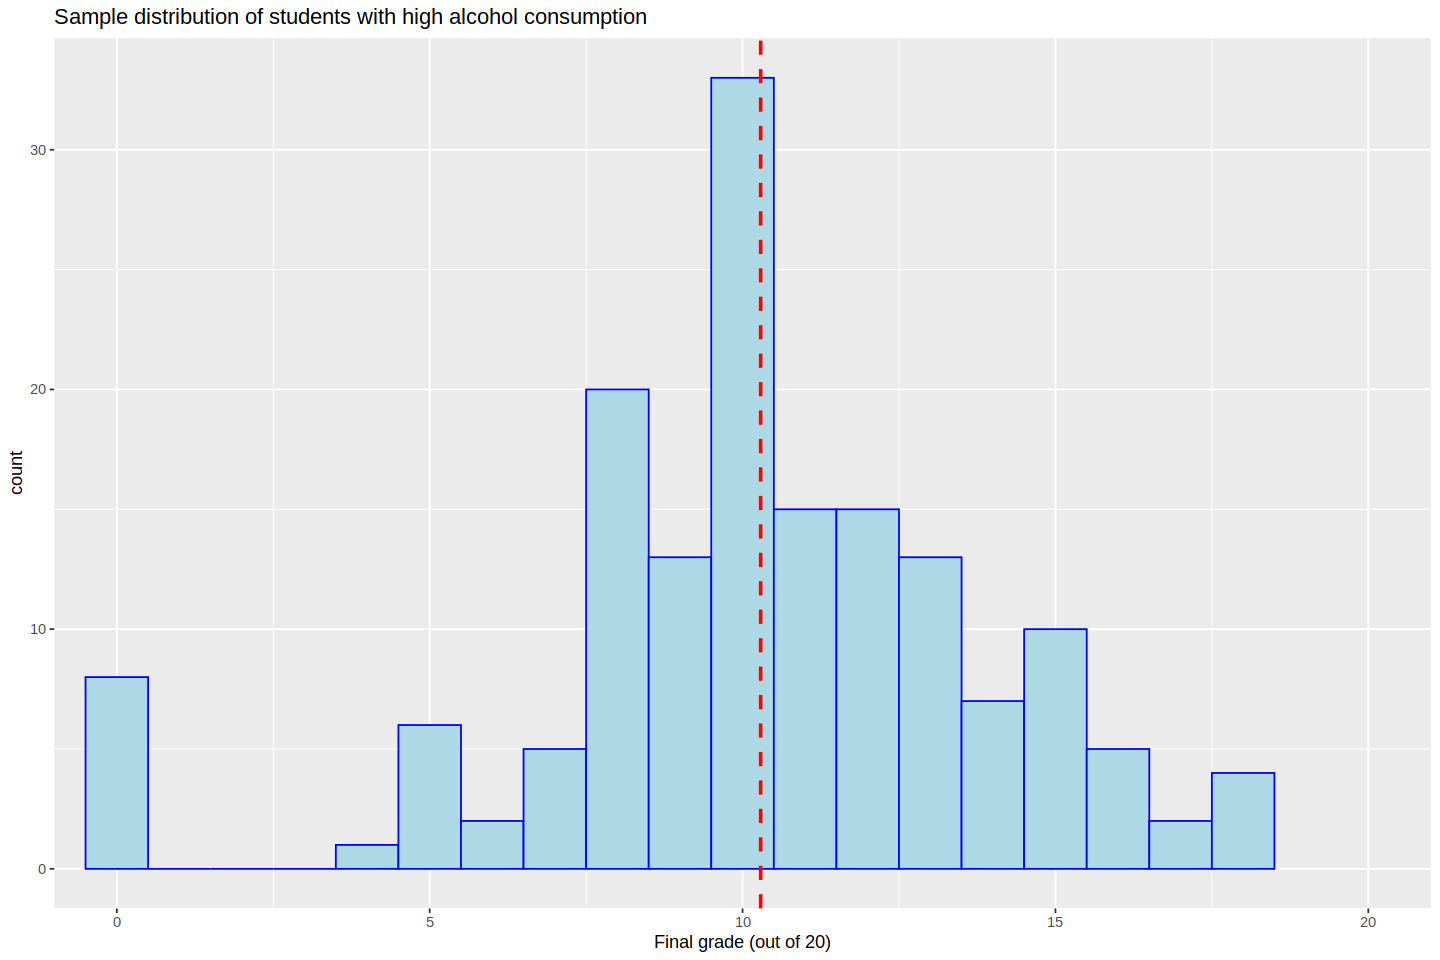

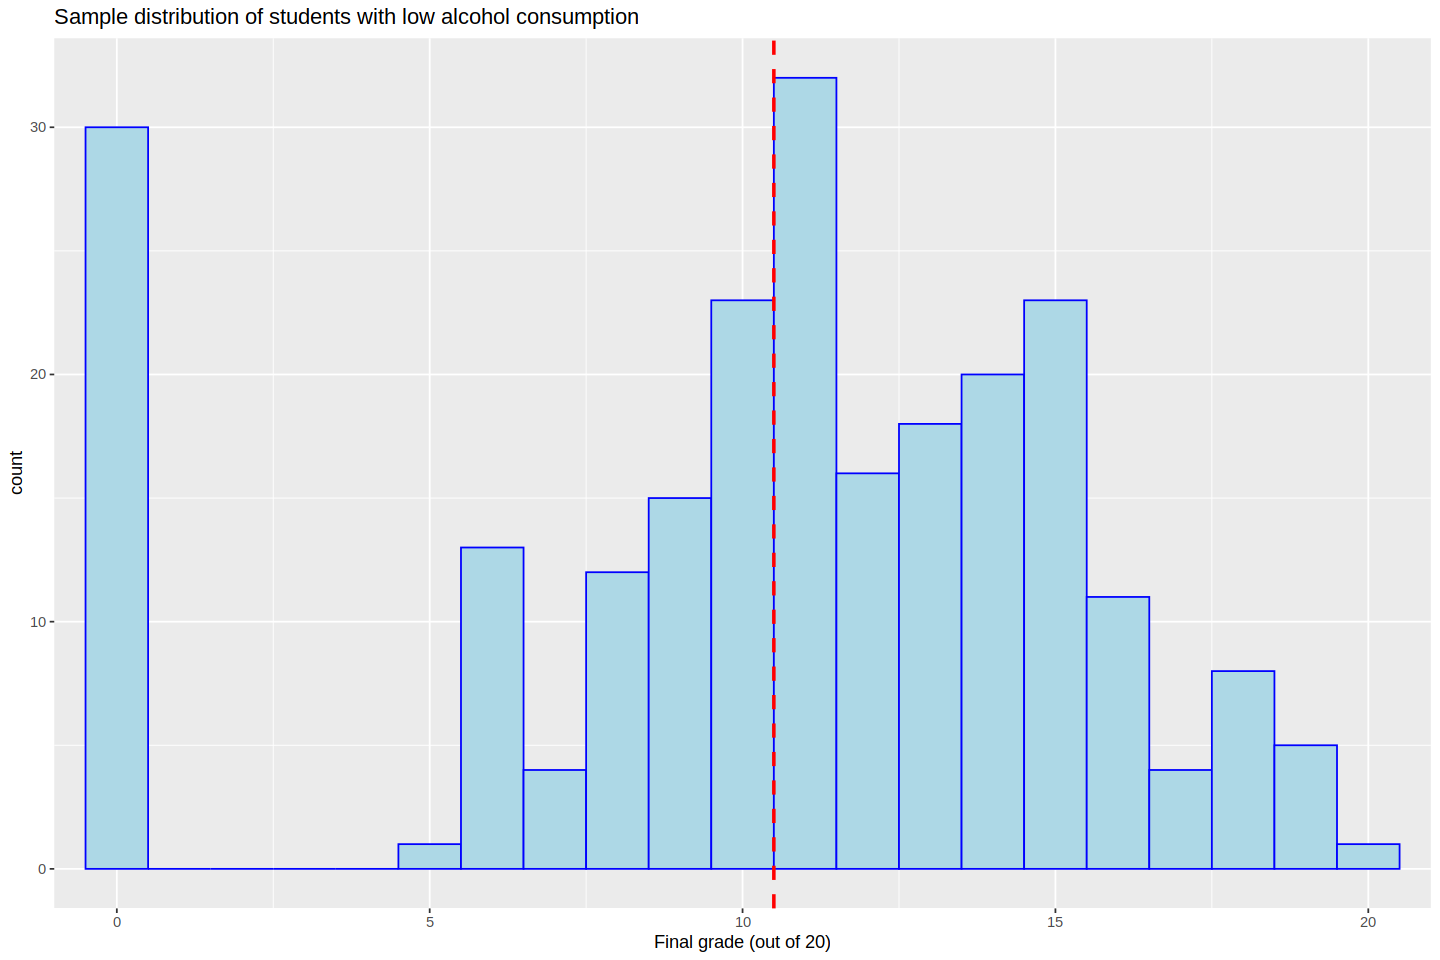

In [9]:
options(repr.plot.width = 12, repr.plot.height = 8)
high_alc_sample_dist <-
    student_data_clean %>%
    filter(high_alc == TRUE) %>%
    ggplot(aes(x = G3)) +
    geom_histogram(binwidth = 1, fill = "lightblue",  color  = "blue") +
    labs(title = "Sample distribution of students with high alcohol consumption", x = "Final grade (out of 20)") +
    geom_vline(aes(xintercept = high_alc_mean), linetype = "dashed", color = "red", linewidth = 1) +
    coord_cartesian(xlim = c(0, 20))


high_alc_sample_dist
    
low_alc_sample_dist <-
    student_data_clean %>%
    filter(high_alc == FALSE) %>%
    ggplot(aes(x = G3)) +
    geom_histogram(binwidth = 1, fill = "lightblue",  color  = "blue") +
    labs(title = "Sample distribution of students with low alcohol consumption", x = "Final grade (out of 20)") +
    geom_vline(aes(xintercept = low_alc_mean), linetype = "dashed", color = "red", linewidth = 1) +
    coord_cartesian(xlim = c(0, 20))


low_alc_sample_dist

### Bootstrap Distribution of Both Groups

We generate a bootstrap distribution for both groups using the original sample size (395) with 1000 reps.

In [6]:
bootstrap_low_consumption <- student_data_clean %>% 
     filter(high_alc == FALSE) %>%
     rep_sample_n(size = total_count, reps = 1000, replace = TRUE) %>%
     group_by(replicate) %>%
     summarize(mean_grade = mean(G3))

bootstrap_high_consumption <- student_data_clean %>%
     filter(high_alc == TRUE) %>%
     rep_sample_n(size = total_count, reps= 1000, replace = TRUE) %>%
     group_by(replicate) %>%
     summarize(mean_grade = mean(G3))

bootstrap_low_consumption
bootstrap_high_consumption

replicate,mean_grade
<int>,<dbl>
1,10.26076
2,10.85063
3,10.55190
⋮,⋮
998,10.54177
999,10.32658
1000,10.54177


replicate,mean_grade
<int>,<dbl>
1,10.34430
2,10.42025
3,10.47595
⋮,⋮
998,10.13418
999,10.37468
1000,10.30633


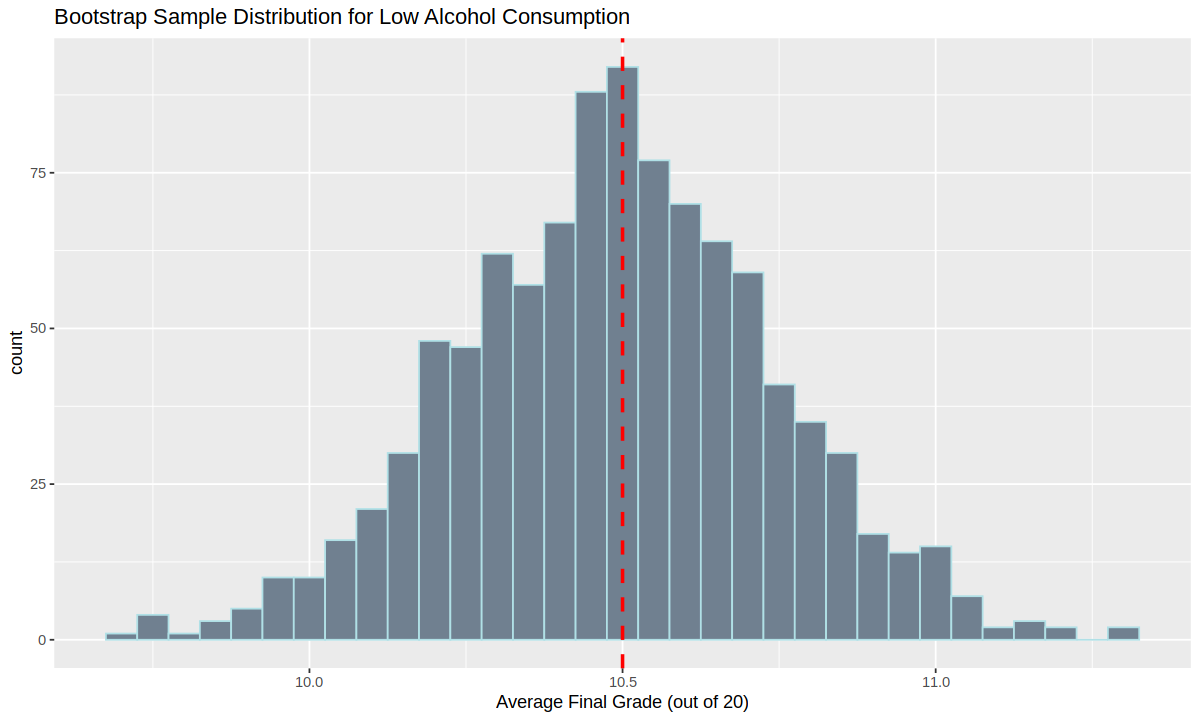

In [7]:
bootstrap_low_consumption_dist <- bootstrap_low_consumption %>% 
         ggplot(aes(x = mean_grade)) + 
         geom_histogram(binwidth = 0.05, fill = "slategray", colour = "powderblue") +
         ggtitle("Bootstrap Sample Distribution for Low Alcohol Consumption") +
         geom_vline(aes(xintercept = low_alc_mean), linetype = "dashed", color = "red", linewidth = 1) +
         xlab("Average Final Grade (out of 20)")

bootstrap_low_consumption_dist

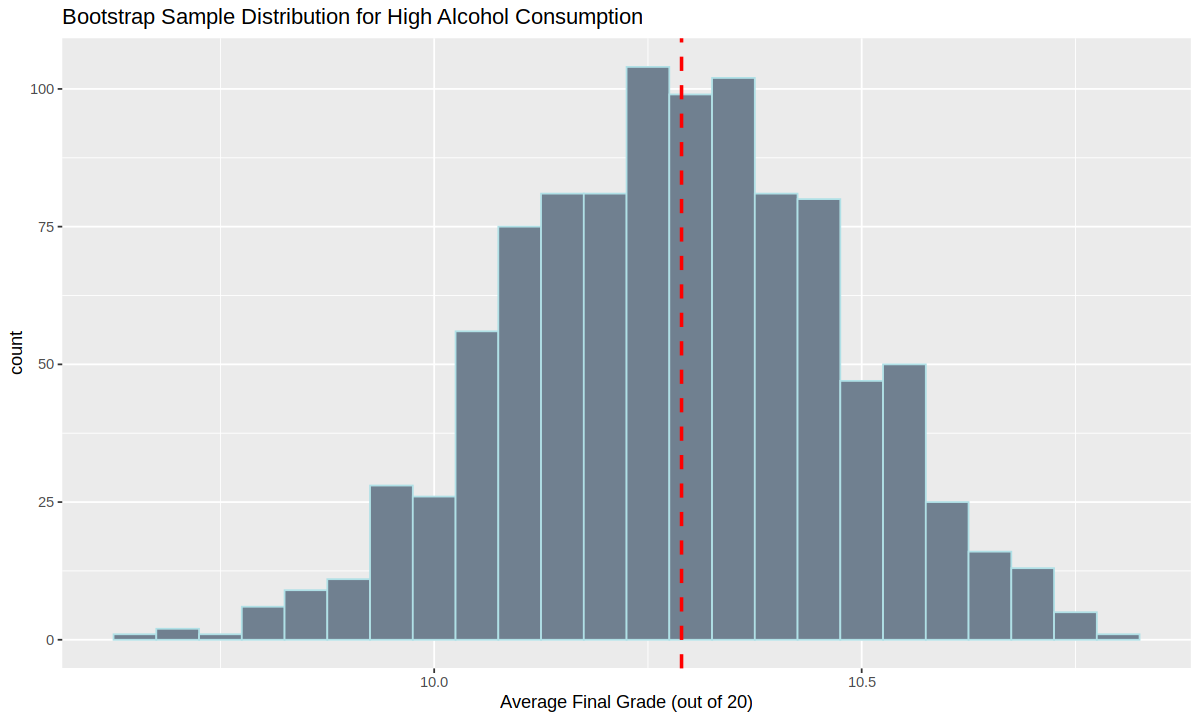

In [8]:
bootstrap_high_consumption_dist <- bootstrap_high_consumption %>% 
         ggplot(aes(x = mean_grade)) + 
         geom_histogram(binwidth = 0.05, fill = "slategray", colour = "powderblue") +
         ggtitle("Bootstrap Sample Distribution for High Alcohol Consumption") +
         geom_vline(aes(xintercept = high_alc_mean), linetype = "dashed", color = "red", linewidth = 1) +
         xlab("Average Final Grade (out of 20)")

bootstrap_high_consumption_dist

# Method


What do you expect to find?

- Our anticipated result, based on existing literature on alcohol consumption, is that students with higher reported alcohol consumption receive lower grades on average. This is supported by the lower raw mean final grade in the high consumption group in our preliminary results. However, the difference is small and we intend to employ hypothesis testing to help us determine whether there is a statistically significant difference. The null hypothesis proposes that students with high alcohol consumption attain the same grades as students with lower alcohol intake. We intend to use a fairly liberal alpha value of 0.1, which our p-value will be compared to. This value was chosen because of the supporting literature on the subject and the limited negative effect that committing a Type I error could cause. Our altered hypothesis, based on the preliminary results obtained above, is that the students reporting higher alcohol assumption attain lower grades on average. Through incorporating bootstrapping, we hope to check for errors and facilitate discussion by comparing the results with theory-based calculations.


- $H_0: \mu_1 - \mu_2 = 0$ and $H_a: \mu_1 - \mu_2 < 0$

What impact could such findings have?
- The results of our research could significantly contribute to the understanding of the impact of alcohol on high school students. Understanding the relationship between consumption and academic grade enables schools and educators to provide specialized resources such as psychological counseling, which in turn can lead to an improvement in students' academic achievements. 

What future questions could this lead to?
 - Are there other factors by which the difference in grades can be caused? For example, students who drink more may have had different life experiences from the students who drink less. Are they a factor into their grades?
    

# References

(1). Michael J. Eckardt, Sandra E. File, et.Effects of Moderate Alcohol Consumption on the Central Nervous System. 30 May 2006. https://doi.org/10.1111/j.1530-0277.1998.tb03695.x

(2). Bushman, B. J., & Cooper, H. M. . Effects of alcohol on human aggression: An intergrative research review. Psychological Bulletin, 107(3), 341–354.(1990). https://doi.org/10.1037/0033-2909.107.3.341

(3). El Ansari W, Stock C, Mills C. Is alcohol consumption associated with poor academic achievement in university students? Int J Prev Med. Oct 2013;4(10):1175-88. PMID: 24319558; PMCID: PMC3843305. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3843305/
